In [1]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import xarray as xr
import calendar
import scipy.stats
import pandas as pd
import datetime
import ipywidgets as widgets
import scipy.io as sio
import pooch

%matplotlib inline

In [2]:
from dask.distributed import Client, LocalCluster


In [3]:
client = Client(threads_per_worker = 1)
client

<Client: 'tcp://127.0.0.1:45933' processes=14 threads=14, memory=63.00 GiB>

2025-08-19 16:50:53,540 - distributed.scheduler - WARNING - Detected different `run_spec` for key ('mean_chunk-0602b271b5ccc8b089fccff40262338d', 46) between two consecutive calls to `update_graph`. This can cause failures and deadlocks down the line. Please ensure unique key names. If you are using a standard dask collections, consider releasing all the data before resubmitting another computation. More details and help can be found at https://github.com/dask/dask/issues/9888. 
Debugging information
---------------------
old task state: released
old run_spec: Alias(('mean_chunk-0602b271b5ccc8b089fccff40262338d', 46)->('getitem-mean_chunk-0602b271b5ccc8b089fccff40262338d', 46))
new run_spec: <Task ('mean_chunk-0602b271b5ccc8b089fccff40262338d', 46) mean_chunk(..., ...)>
old dependencies: {('getitem-mean_chunk-0602b271b5ccc8b089fccff40262338d', 46)}
new dependencies: frozenset({('getitem-0a088661c6d221365be6f1ecbac5bf0b', 46)})

2025-08-19 16:50:54,962 - distributed.scheduler - WARNING 

In [4]:
today = datetime.datetime.today().strftime('%Y-%m-%d')

# Load sea ice extent time series
NSIDC sea ice index, v4.

In [5]:
fname_sie_S = pooch.retrieve(
    url="https://noaadata.apps.nsidc.org/NOAA/G02135/south/daily/data/S_seaice_extent_daily_v4.0.csv",
    known_hash=None,
    path='./'
)
SIE_obs_daily = pd.read_csv(fname_sie_S, header=[0], skiprows=[1], skipinitialspace=True)

SIE_obs_daily['date'] = pd.to_datetime(SIE_obs_daily.Year*10000+SIE_obs_daily.Month*100+SIE_obs_daily.Day,format='%Y%m%d')
SIE_obs_daily.set_index(SIE_obs_daily['date'], inplace=True, drop=True)



In [6]:
SIE_obs_daily = SIE_obs_daily.drop('Source Data', axis=1)

In [7]:
SIE_obs_daily.tail()

Year  Month  Day  Extent  Missing       date
date                                                    
2025-08-13  2025      8   13  16.316      0.0 2025-08-13
2025-08-14  2025      8   14  16.482      0.0 2025-08-14
2025-08-15  2025      8   15  16.504      0.0 2025-08-15
2025-08-16  2025      8   16  16.492      0.0 2025-08-16
2025-08-17  2025      8   17  16.498      0.0 2025-08-17

In [8]:
SIE_obs_monthly = SIE_obs_daily.groupby(pd.Grouper(freq='ME')).mean()

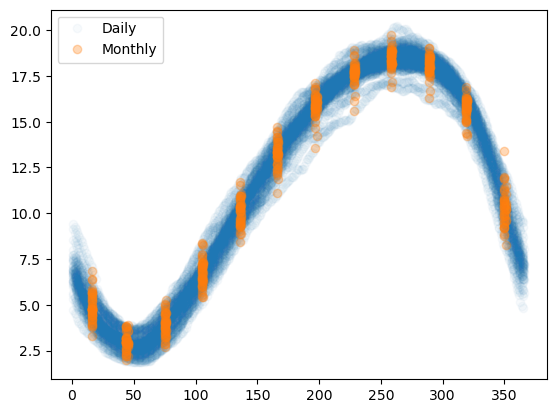

In [9]:
plt.plot(SIE_obs_daily.index.dayofyear, SIE_obs_daily.Extent, 'o', alpha=0.03, label='Daily')
plt.plot(SIE_obs_monthly.index.dayofyear-15, SIE_obs_monthly['Extent'], 'o', alpha=0.3, label='Monthly')
plt.legend()
plt.show()

# Load ERA5 meridional wind

Make an index, and then analyse sea ice extent related to that.


In [10]:
ERA5_u10 = xr.open_mfdataset("/g/data/rt52/era5/single-levels/monthly-averaged/10u/*/10u*.nc", )

In [11]:
ERA5_v10 = xr.open_mfdataset("/g/data/rt52/era5/single-levels/monthly-averaged/10v/*/10v*.nc")

In [12]:
ERA5_v10

<xarray.Dataset> Size: 7GB
Dimensions:    (time: 796, latitude: 721, longitude: 1440)
Coordinates:
  * longitude  (longitude) float32 6kB -180.0 -179.8 -179.5 ... 179.5 179.8
  * latitude   (latitude) float32 3kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * time       (time) datetime64[ns] 6kB 1959-01-01 1959-02-01 ... 2025-04-01
Data variables:
    v10        (time, latitude, longitude) float64 7GB dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2022-07-14 20:35:49 UTC+1000 by era5_replication_tools-1.10...
    license:      Licence to use Copernicus Products: https://apps.ecmwf.int/...
    summary:      ERA5 is the fifth generation ECMWF atmospheric reanalysis o...
    title:        ERA5 single-levels monthly-averaged 10m_v_component_of_wind...

In [13]:
ERA5_v10 = ERA5_v10.sel(time=slice('1979-01-01',datetime.date.today()))

In [14]:
zm_v = ERA5_v10.v10.groupby('time.month').mean(dim=['longitude','time'])

Text(0, 0.5, 'v10')

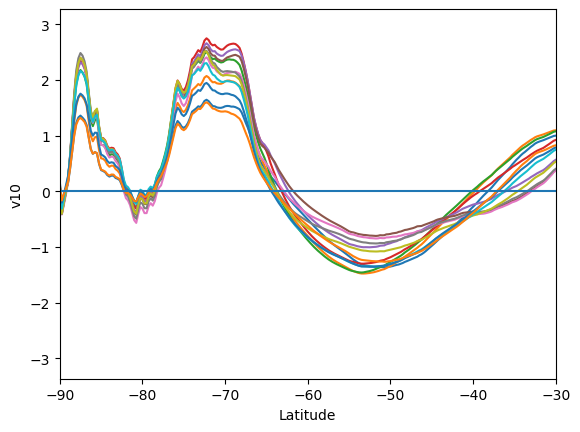

In [15]:
for t in range(1,13):
    plt.plot(zm_v.latitude, zm_v.loc[dict(month=t)])
    
plt.xlim(-90,-30)
plt.hlines(0, -90,-30)
plt.xlabel("Latitude")
plt.ylabel('v10')

In [16]:
v10_at_70S = ERA5_v10.v10.sel(latitude=slice(-60,-70)).mean(dim='latitude')
zm_v10_at_70S = v10_at_70S.mean(dim=['longitude'])

In [17]:
v10_at_70S_mean = zm_v10_at_70S.groupby('time.month').mean(dim='time').persist()
v10_at_70S_std = zm_v10_at_70S.groupby('time.month').std(dim='time').persist()

Text(0, 0.5, 'v10, 60-70S')

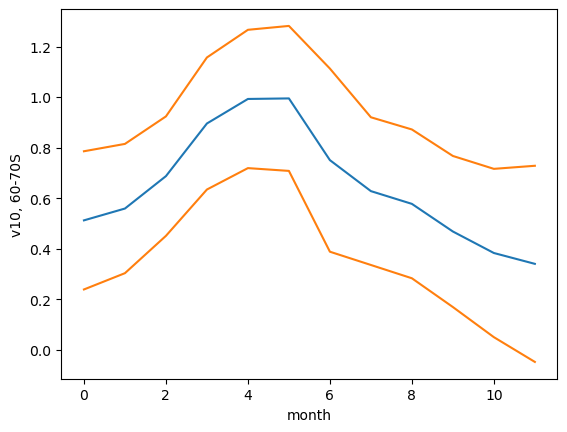

In [18]:
plt.plot(v10_at_70S_mean)
plt.plot(v10_at_70S_mean+v10_at_70S_std)
plt.plot(v10_at_70S_mean-v10_at_70S_std, color='C1')
plt.xlabel('month')
plt.ylabel('v10, 60-70S')

In [19]:
def is_month(month, month_check):
    return (month == month_check)

Started month =  1
Started month =  2
Started month =  3
Started month =  4
Started month =  5
Started month =  6
Started month =  7
Started month =  8
Started month =  9
Started month =  10
Started month =  11
Started month =  12


Text(0.5, 0, 'Meridional wind anomaly')

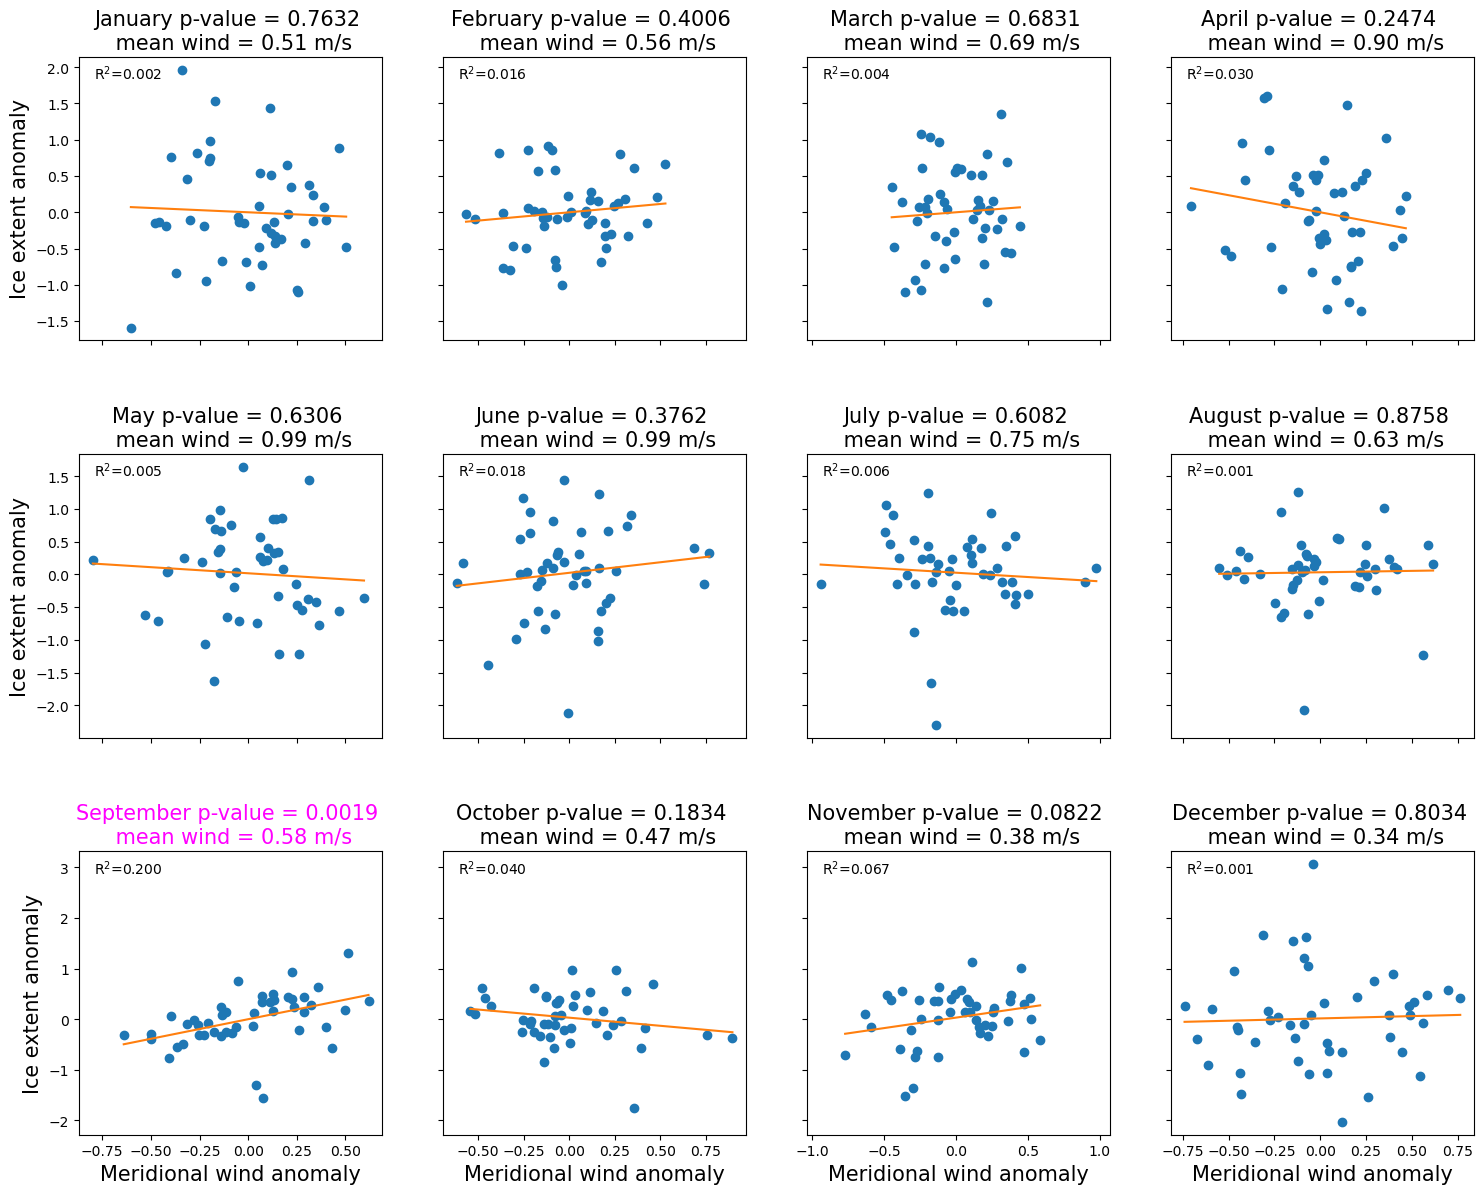

In [20]:
mnth_zm_slopes = np.zeros(12)
mnth_zm_intercepts = np.zeros(12)
mnth_zm_rvalues = np.zeros(12)
mnth_zm_pvalues = np.zeros(12)
mnth_zm_stderrs = np.zeros(12)

month_abbrs = ['JAN', 'FEB', 'MAR', 'APR', 'MAY', 'JUN', 'JUL', 'AUG', 'SEP', 'OCT', 'NOV', 'DEC']

f, axarr = plt.subplots(3, 4, sharex='col', sharey='row', figsize=(18,14))
f.subplots_adjust(hspace=0.4)

for month in range(12):
    print('Started month = ', month+1)
    j = int(np.floor(month/4))
    i = np.mod(month,4)
    
    wind = zm_v10_at_70S.sel(time=is_month(zm_v10_at_70S['time.month'], month+1))
    wind_mean = wind.mean()
    wind = wind - wind.mean()
    ice = SIE_obs_monthly['Extent'][SIE_obs_monthly.Month==month+1]
    ice = ice - ice.mean()
    # wind data is often delayed, so we may need to dump the last item from ice
    if len(ice) > len(wind):
        ice = ice[:-1]
        
    (mnth_zm_slopes[month], mnth_zm_intercepts[month], mnth_zm_rvalues[month], 
        mnth_zm_pvalues[month], mnth_zm_stderrs[month]) = scipy.stats.linregress(
                        wind, ice)
    
    axarr[j,i].plot(wind, ice, 'o')
    if mnth_zm_pvalues[month] <= 0.05/12.:
        axarr[j,i].set_title('{} p-value = {:.04f} \n mean wind = {:.02f} m/s'.format(calendar.month_name[month+1],
                             mnth_zm_pvalues[month], float(wind_mean.data)), fontsize=15, color='magenta')
    else:
        axarr[j,i].set_title('{} p-value = {:.04f} \n mean wind = {:.02f} m/s'.format(calendar.month_name[month+1],
                             mnth_zm_pvalues[month], float(wind_mean.data)), fontsize=15)
    wind = np.linspace(wind.min().values, wind.max().values, 100)
    axarr[j,i].plot(wind, wind*mnth_zm_slopes[month] + mnth_zm_intercepts[month])
    axarr[j,i].text(0.05, 0.92, 'R$^2$={:.03f}'.format(mnth_zm_rvalues[month]**2),
                    transform=axarr[j,i].transAxes)
    
axarr[0,0].set_ylabel('Ice extent anomaly', fontsize='15')
axarr[1,0].set_ylabel('Ice extent anomaly', fontsize='15')
axarr[2,0].set_ylabel('Ice extent anomaly', fontsize='15')
axarr[2,0].set_xlabel('Meridional wind anomaly', fontsize='15')
axarr[2,1].set_xlabel('Meridional wind anomaly', fontsize='15')
axarr[2,2].set_xlabel('Meridional wind anomaly', fontsize='15')
axarr[2,3].set_xlabel('Meridional wind anomaly', fontsize='15')

    
# plt.savefig('/plots/70S_merid_wind_Vs_SIE.pdf', bbox_inches='tight')

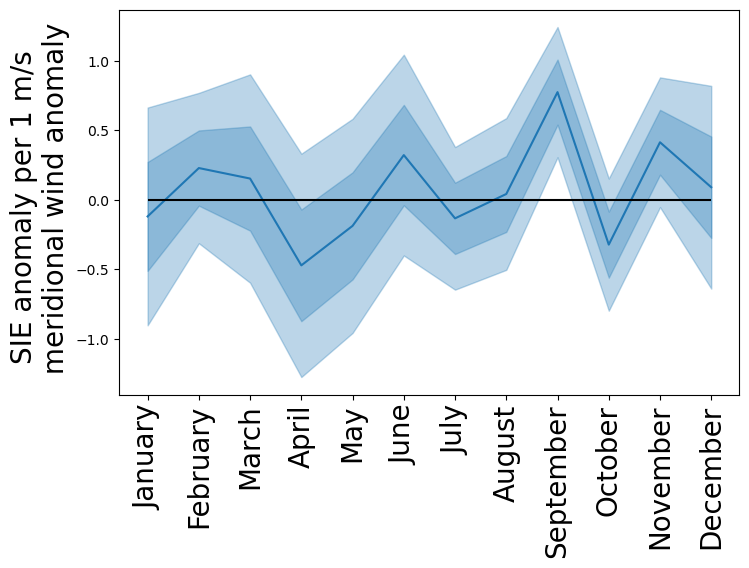

In [21]:
plt.figure(figsize=(8,5))
plt.plot(np.arange(12), mnth_zm_slopes)
plt.fill_between(np.arange(12), mnth_zm_slopes - mnth_zm_stderrs,
                 mnth_zm_slopes + mnth_zm_stderrs, alpha=0.3, color='C0')

plt.fill_between(np.arange(12), mnth_zm_slopes - 2*mnth_zm_stderrs,
                 mnth_zm_slopes + 2*mnth_zm_stderrs, alpha=0.3, color='C0')

plt.ylabel('SIE anomaly per 1 m/s \n meridional wind anomaly', fontsize=20)
plt.xticks( np.arange(12), calendar.month_name[1:13], rotation=90 ,fontsize=20)

plt.hlines(0,0,11, 'k')

# plt.savefig('plots/SIE-wind-regression.pdf', bbox_inches='tight')

# NOT WORKING BELOW HERE

# Looking at regional signals

In [ ]:
nbins = 36
bins = np.linspace(0,360,nbins+1)
bin_centres = (bins[1:] + bins[:-1])/2.

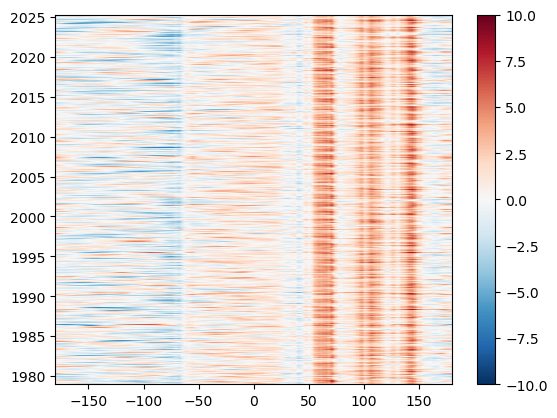

In [133]:
plt.pcolormesh(ERA5_v10.longitude, ERA5_v10.time, v10_at_70S, cmap='RdBu_r', vmin=-10, vmax=10)
plt.colorbar()

In [24]:
import glob
import os
import datetime

In [25]:
# using NSIDC products carefully

icec_files = glob.glob('/Users/doddridge/Documents/Edward/Research/datasets/'+
                       'observations/sea_ice/nsidc0051_gsfc_nasateam_seaice/nt*.bin')
area_file = ('/Users/doddridge/Documents/Edward/Research/datasets/observations/'+
             'sea_ice/nsidc0051_gsfc_nasateam_seaice/pss25area_v3.dat')
lons_file = ('/Users/doddridge/Documents/Edward/Research/datasets/observations/'+
             'sea_ice/nsidc0051_gsfc_nasateam_seaice/pss25lons_v3.dat')


def calc_sea_ice_extent(icec_files, area_file, lons_file):

    with open(area_file, 'rb') as f:
        pss25area = np.fromfile(f, dtype=np.uint32)
        pss25area = pss25area.reshape((332, 316))


    with open(lons_file, 'rb') as f:
        pss25lons = np.fromfile(f, dtype='<i4')
        pss25lons = pss25lons.reshape((332, 316))/1e5 + 360
        pss25lons = np.mod(pss25lons, 360)

    

    region_mask = np.ones((nbins,332,316))
    for i in range(nbins):
        region_mask[i,:,:][pss25lons<=bins[i]] = 0
        region_mask[i,:,:][pss25lons>bins[i+1]] = 0


    columns=['date', 'extent'] + ['lon_' + s for s in bin_centres.astype(int).astype(str).tolist()]
    SIE_from_conc = pd.DataFrame(columns=columns)


    for icefile in icec_files:
        _, datafile = os.path.split(icefile)
        year = int(datafile[3:7])
        month = int(datafile[7:9])
        day = int(datafile[9:11])

        timestamp = datetime.datetime(year,month,day)

        with open(icefile, 'rb') as fr:
            hdr = fr.read(300)
            ice = np.fromfile(fr, dtype=np.uint8)

        # reshape to rectangle
        ice = ice.reshape((332, 316))
        # mask out the land and convert to decimal percentage
        ice_masked = np.ma.masked_where(ice>=251, ice)/250.

        # calculate total extent
        masked_area = np.ma.masked_where(ice_masked<=0.15, pss25area)
        # calculate extent and convert to 10^6 km^2
        extent = np.sum(masked_area)/1e9

        regional_extent = np.zeros((nbins))
        for i in range(nbins):
            regional_masked_area = np.ma.masked_where(region_mask[i,:,:]==0, masked_area)
            regional_extent[i] = np.sum(regional_masked_area)/1e9

        df2 = pd.DataFrame([[timestamp, extent]+regional_extent.tolist()], columns=columns)
    #     print df2
        SIE_from_conc = SIE_from_conc.append(df2, ignore_index=True)


    SIE_from_conc = SIE_from_conc.set_index('date')
    
    return pss25area, pss25lons, SIE_from_conc

In [26]:
pss25area, pss25lons, SIE_from_conc = calc_sea_ice_extent(icec_files, area_file, lons_file)

/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:60: UserWarning: Warning: converting a masked element to nan.


In [27]:
SIE_from_conc_mnthly_means = SIE_from_conc.groupby(pd.Grouper(freq='M')).mean()

In [28]:
SIE_trimmed = SIE_from_conc_mnthly_means['1979':'2016']

In [29]:
SIE_trimmed_ann_mean = SIE_trimmed.groupby(SIE_trimmed.index.year).mean()

In [30]:
print(SIE_trimmed_ann_mean.loc[1981].sum() - SIE_trimmed_ann_mean.loc[1981].extent)
print(SIE_trimmed_ann_mean.loc[1981].extent)
# new

11.47587316989966
11.387497357049156


In [31]:
print(SIE_trimmed_ann_mean.loc[1981].sum() - SIE_trimmed_ann_mean.loc[1981].extent)
print(SIE_trimmed_ann_mean.loc[1981].extent)

11.47587316989966
11.387497357049156


In [32]:
v70_bins = ERA_winds.v10.loc[dict(latitude=np.linspace(-70, -60, 11))].groupby_bins('longitude',
                        np.linspace(0,360,nbins+1)).mean(dim=['longitude', 'latitude'])

In [33]:
v70_bins

<xarray.DataArray 'v10' (time: 457, longitude_bins: 36)>
array([[ 1.287576,  1.640347,  1.409415, ...,  1.032141,  0.558291,  1.020092],
       [ 2.878729,  2.514411,  0.617927, ..., -0.142129,  0.78241 ,  2.340786],
       [ 2.058334, -0.338839, -1.3899  , ...,  2.659276,  2.286978,  2.67688 ],
       ...,
       [ 0.288505,  0.788901,  1.041031, ..., -1.809995, -1.346538, -0.551398],
       [ 0.840114,  1.584763,  1.51886 , ...,  0.977266,  0.221618,  0.154555],
       [ 1.93015 ,  0.979858, -0.238082, ..., -0.632866,  0.328535,  1.251221]],
      dtype=float32)
Coordinates:
  * longitude_bins  (longitude_bins) object (0.0, 10.0] (10.0, 20.0] ...
  * time            (time) datetime64[ns] 1979-01-01 1979-02-01 1979-03-01 ...

<IPython.core.display.Javascript object>


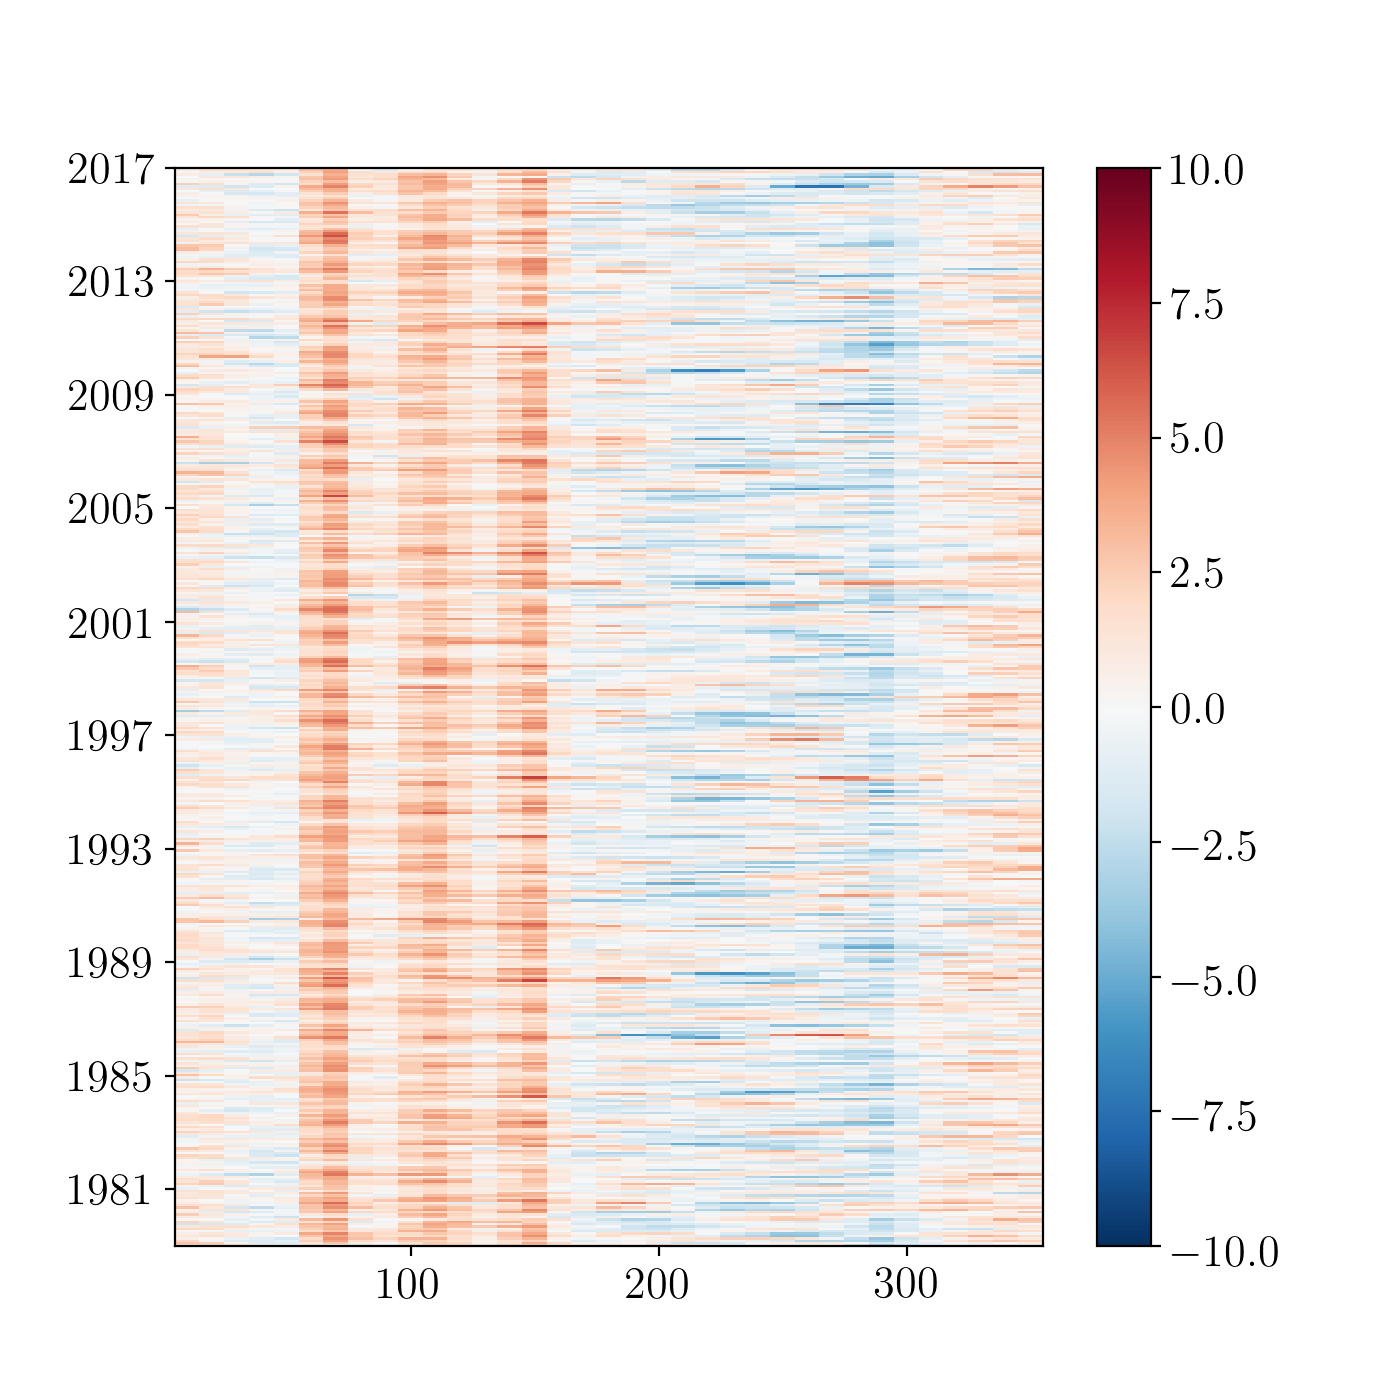

In [34]:
plt.pcolormesh(bin_centres, v70_bins.time, v70_bins, cmap='RdBu_r', vmin=-10, vmax=10)
plt.colorbar()

### Regional wind trends

<IPython.core.display.Javascript object>


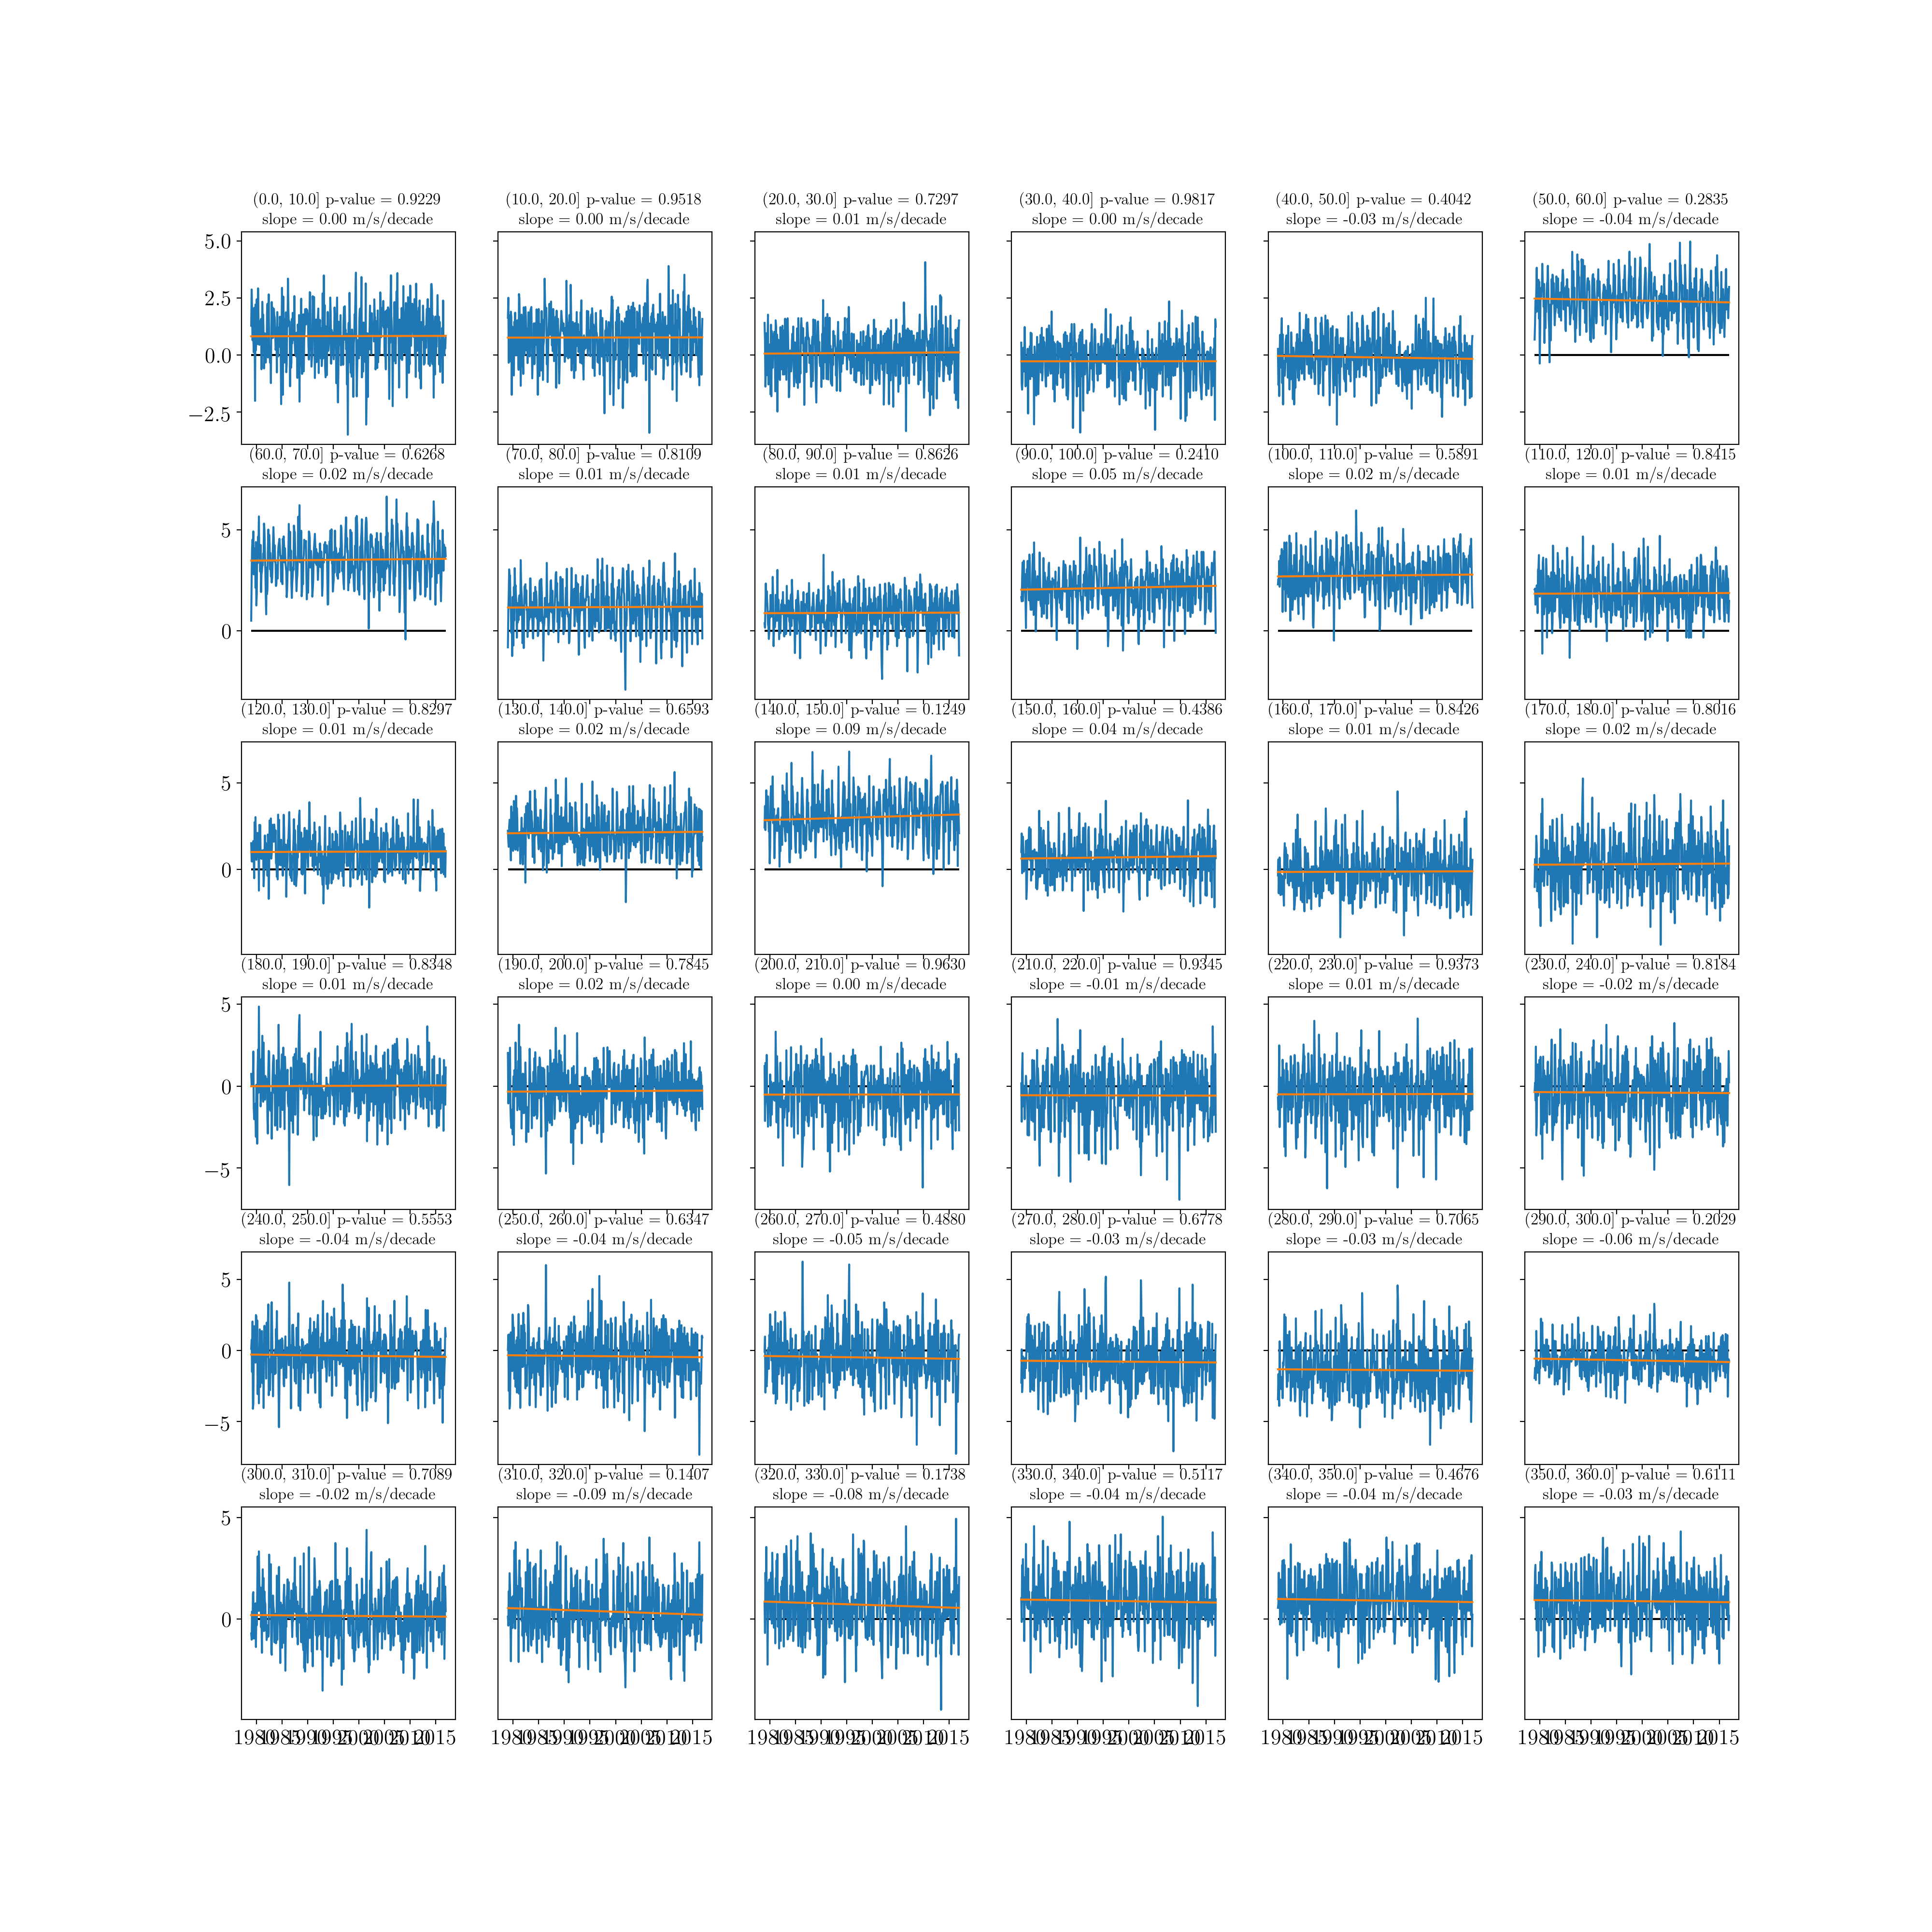

In [35]:
slopes = np.zeros((nbins))
intercepts = np.zeros((nbins))
rvalues = np.zeros((nbins))
pvalues = np.zeros((nbins))
stderrs = np.zeros((nbins))


nrows = 6
ncols = 6
f, axarr = plt.subplots(nrows, ncols, sharex='col', sharey='row', figsize=(20,20))

    
for lonbin in range(nbins):
    wind = v70_bins.loc[dict(longitude_bins=v70_bins.longitude_bins[lonbin])]
    wind_monthly_mean = wind.groupby('time.month').mean(dim='time')
    
    j = int(np.floor(lonbin/ncols))
    i = np.mod(lonbin, ncols)
    
    (slopes[lonbin], intercepts[lonbin], rvalues[lonbin], 
        pvalues[lonbin], stderrs[lonbin]) = scipy.stats.linregress(
                            np.arange(456.), wind[:-1])# - np.tile(wind_monthly_mean, 38))    

    axarr[j,i].plot(wind.time[:-1], wind[:-1])# - np.tile(wind_monthly_mean, 38))
    axarr[j,i].plot(wind.time[:-1], (np.arange(456.)*slopes[lonbin]) + intercepts[lonbin])
    axarr[j,i].hlines(0,wind.time[0].data, wind.time[-2].data)
    
    if pvalues[lonbin] < 0.05:
        axarr[j,i].set_title('{} p-value = {:.04f} \n slope = {:.02f} m/s/decade'.format(
                v70_bins.longitude_bins[lonbin].data, pvalues[lonbin], float(slopes[lonbin]*120.)), 
                                 fontsize=12, color='magenta')
    else:
        axarr[j,i].set_title('{} p-value = {:.04f} \n slope = {:.02f} m/s/decade'.format(
                v70_bins.longitude_bins[lonbin].data, pvalues[lonbin], float(slopes[lonbin]*120.)), 
                                 fontsize=12, color='k')


In [59]:
mnth_regional_slopes = np.zeros((12, nbins))
mnth_regional_intercepts = np.zeros((12, nbins))
mnth_regional_rvalues = np.zeros((12, nbins))
mnth_regional_pvalues = np.zeros((12, nbins))
mnth_regional_stderrs = np.zeros((12, nbins))

month_abbrs = ['JAN', 'FEB', 'MAR', 'APR', 'MAY', 'JUN', 'JUL', 'AUG', 'SEP', 'OCT', 'NOV', 'DEC']

for lonbin in range(nbins):
    # regress regional wind and regional ice extent by month
    f, axarr = plt.subplots(3, 4, sharex='col', sharey='row', figsize=(18,12))

    for month in range(12):
        j = int(np.floor(month/4))
        i = np.mod(month,4)

        wind = v70_bins.sel(time=is_month(v70_bins['time.month'], month + 1)).loc[dict(
            time=np.arange('1979-{:02d}'.format(month+1),'2017', '12', dtype='datetime64'),
            longitude_bins=v70_bins.longitude_bins[lonbin])]
        wind_mean = wind.mean()
        wind = wind - wind.mean()
        
        ice = SIE_trimmed.loc[SIE_trimmed.index.month==month+1][SIE_trimmed.columns[lonbin+1]]
        ice = ice - ice.mean()

        (mnth_regional_slopes[month, lonbin], mnth_regional_intercepts[month, lonbin], mnth_regional_rvalues[month, lonbin], 
        mnth_regional_pvalues[month, lonbin], mnth_regional_stderrs[month, lonbin]) = scipy.stats.linregress(
                            wind, ice)    

        axarr[j,i].plot(wind, ice, 'o')
        if mnth_regional_pvalues[month,lonbin] <= 0.05/12./36:
            axarr[j,i].set_title('{} p-value = {:.04f} \n mean wind = {:.02f} m/s'.format(
                calendar.month_name[month+1], mnth_regional_pvalues[month,lonbin], float(wind_mean.data)), 
                                 fontsize=15, color='magenta')
        else:
            axarr[j,i].set_title('{} p-value = {:.04f} \n mean wind = {:.02f} m/s'.format(
                calendar.month_name[month+1], mnth_regional_pvalues[month,lonbin], float(wind_mean.data)), 
                                 fontsize=15)

        wind = np.linspace(wind.min(), wind.max(), 100)
        axarr[j,i].plot(wind, wind*mnth_regional_slopes[month, lonbin] + mnth_regional_intercepts[month, lonbin])
        axarr[j,i].text(0.05, 0.95, 'R$^2$={:.03f}'.format(mnth_regional_rvalues[month, lonbin]**2),
                        transform=axarr[j,i].transAxes)

    axarr[0,0].set_ylabel('Ice extent anomaly', fontsize='15')
    axarr[1,0].set_ylabel('Ice extent anomaly', fontsize='15')
    axarr[2,0].set_ylabel('Ice extent anomaly', fontsize='15')
    axarr[2,0].set_xlabel('Meridional wind anomaly', fontsize='15')
    axarr[2,1].set_xlabel('Meridional wind anomaly', fontsize='15')
    axarr[2,2].set_xlabel('Meridional wind anomaly', fontsize='15')
    axarr[2,3].set_xlabel('Meridional wind anomaly', fontsize='15')
    f.suptitle('Longitude range = {0}'.format(v70_bins.longitude_bins[lonbin].data), fontsize=15)


    plt.savefig('/Users/doddridge/Desktop/SIE_regresssion/70S_merid_wind_Vs_SIE_lonbin_{0}.pdf'.format(
                v70_bins.longitude_bins[lonbin].data), bbox_inches='tight')
    plt.close()

/anaconda3/envs/py36/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/anaconda3/envs/py36/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/anaconda3/envs/py36/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/anaconda3/envs/py36/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/anaconda3/envs/py36/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] n

In [62]:
hist_bins = np.linspace(-0.05, 0.05, num=20)
for month in range(12):
    plt.hist(mnth_regional_slopes[month,:][~np.isnan(mnth_regional_slopes[month,:])],bins=hist_bins)
    plt.title('Regression slopes in {0}'.format(calendar.month_name[month+1]))
    plt.ylim(0, 15)
    plt.vlines(mnth_zm_slopes[month]/36., 0, 14)
    plt.savefig('/Users/doddridge/Desktop/SIE_regresssion/regional_regression_slopes_month_{0}_{1}.pdf'.format(month, calendar.month_name[month+1]))
    plt.close()

/anaconda3/envs/py36/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/anaconda3/envs/py36/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/anaconda3/envs/py36/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/anaconda3/envs/py36/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/anaconda3/envs/py36/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] n

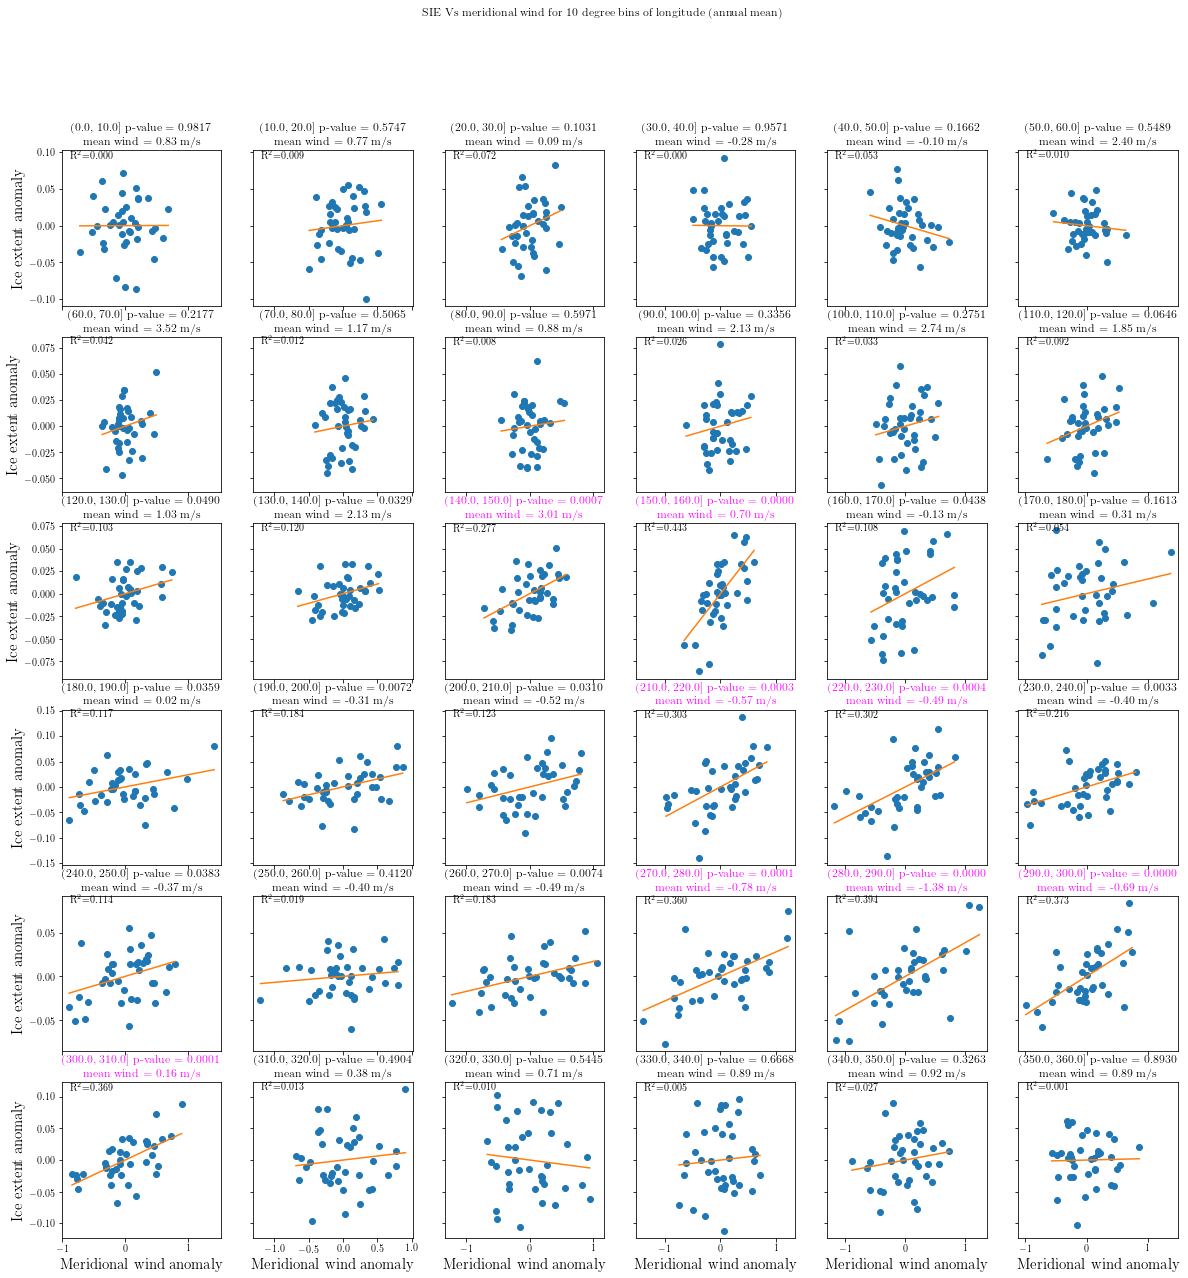

In [130]:
# Annual mean regional

ann_regional_slopes = np.zeros((nbins))
ann_regional_intercepts = np.zeros((nbins))
ann_regional_rvalues = np.zeros((nbins))
ann_regional_pvalues = np.zeros((nbins))
ann_regional_stderrs = np.zeros((nbins))


f, axarr = plt.subplots(6, 6, sharex='col', sharey='row', figsize=(20,20))

for lonbin in xrange(nbins):
    # regress regional wind and regional ice extent

    j = int(np.floor(lonbin/6))
    i = np.mod(lonbin,6)

    wind = v70_bins.groupby('time.year').mean(dim='time')[:-1].loc[dict(
        longitude_bins=v70_bins.longitude_bins[lonbin])]
    wind_mean = wind.mean()
    wind = wind - wind.mean()

    # use annual mean
    ice = SIE_trimmed_ann_mean[SIE_trimmed_ann_mean.columns[lonbin+1]]
    ice = ice - ice.mean()

    (ann_regional_slopes[lonbin], ann_regional_intercepts[lonbin], ann_regional_rvalues[lonbin], 
    ann_regional_pvalues[lonbin], ann_regional_stderrs[lonbin]) = scipy.stats.linregress(
                        wind, ice)    

    axarr[j,i].plot(wind, ice, 'o')
    if ann_regional_pvalues[lonbin] <= 0.05/36.:
        axarr[j,i].set_title('{} p-value = {:.04f} \n mean wind = {:.02f} m/s'.format(
            v70_bins.longitude_bins[lonbin].data, ann_regional_pvalues[lonbin], float(wind_mean.data)), 
                             fontsize=12, color='magenta')
    else:
        axarr[j,i].set_title('{} p-value = {:.04f} \n mean wind = {:.02f} m/s'.format(
            v70_bins.longitude_bins[lonbin].data, ann_regional_pvalues[lonbin], float(wind_mean.data)), 
                             fontsize=12)
    axarr[j,i].text(0.05, 0.95, 'R$^2$={:.03f}'.format(ann_regional_rvalues[lonbin]**2),
                        transform=axarr[j,i].transAxes)

    wind = np.linspace(wind.min(), wind.max(), 100)
    axarr[j,i].plot(wind, wind*ann_regional_slopes[lonbin] + ann_regional_intercepts[lonbin])

for j in xrange(6):
    axarr[j,0].set_ylabel('Ice extent anomaly', fontsize='15')
    axarr[5,j].set_xlabel('Meridional wind anomaly', fontsize='15')
f.suptitle('SIE Vs meridional wind for 10 degree bins of longitude (annual mean)')

plt.savefig('/Users/doddridge/Desktop/SIE_regresssion/70S_ann_mean_merid_wind_Vs_SIE_by_lonbin.pdf',
            bbox_inches='tight')
# plt.close()


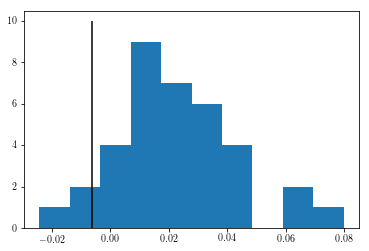

In [132]:
plt.hist(ann_regional_slopes)
plt.vlines(ann_zm_slope/36, 0, 10)

## Specific regions identified by wind trends in Hlland & Kwok

### sectors:
- 350-020
- 100-120
- 200-240
- 300-310
- 320-330

# Effect on ocean temperature and salinity

The wind should push ice out and, after it melts, this should make the water fresher and colder. Can use the griddded Argo dataset north of 62 S, Need to use isolated profiles and marine mammal data to the south.

In [19]:
argo_T = xr.open_dataset(data_cat.ext_argo_T())
argo_S = xr.open_dataset(data_cat.ext_argo_S())

In [20]:
argo_T

<xarray.Dataset>
Dimensions:                   (LATITUDE: 145, LONGITUDE: 360, PRESSURE: 58, TIME: 168)
Coordinates:
  * LATITUDE                  (LATITUDE) float32 -64.5 -63.5 -62.5 -61.5 ...
  * LONGITUDE                 (LONGITUDE) float32 20.5 21.5 22.5 23.5 24.5 ...
  * PRESSURE                  (PRESSURE) float32 2.5 10.0 20.0 30.0 40.0 ...
  * TIME                      (TIME) datetime64[ns] 2004-01-01 2004-02-01 ...
Data variables:
    ARGO_TEMPERATURE_MEAN     (PRESSURE, LATITUDE, LONGITUDE) float32 ...
    BATHYMETRY_MASK           (PRESSURE, LATITUDE, LONGITUDE) float32 ...
    ARGO_TEMPERATURE_ANOMALY  (TIME, PRESSURE, LATITUDE, LONGITUDE) float32 ...
Attributes:
    history:  FERRET V5.51    9-Jun-15FERRET V5.51   28-Aug-15FERRET V5.51   ...

In [52]:
argo_T_bins = argo_T.ARGO_TEMPERATURE_ANOMALY.loc[dict(LATITUDE=np.linspace(-64.5, -58.5, 7))].groupby_bins('LONGITUDE',
                        np.linspace(0,360,nbins+1)).mean(dim=['LATITUDE', 'LONGITUDE'])

In [53]:
argo_T_bins

<xarray.DataArray 'ARGO_TEMPERATURE_ANOMALY' (TIME: 168, PRESSURE: 58, LONGITUDE_bins: 36)>
array([[[          nan,           nan, ...,  8.747500e-01,  8.667000e-01],
        [          nan,           nan, ...,  8.627000e-01,  8.544250e-01],
        ...,
        [          nan,           nan, ..., -3.812500e-02, -4.050000e-02],
        [          nan,           nan, ..., -2.620000e-02, -3.117500e-02]],

       [[          nan,           nan, ...,  1.615525e+00,  1.633875e+00],
        [          nan,           nan, ...,  1.617425e+00,  1.630775e+00],
        ...,
        [          nan,           nan, ..., -3.150000e-03, -1.400000e-02],
        [          nan,           nan, ..., -1.375000e-02, -2.747500e-02]],

       ...,

       [[          nan,           nan, ..., -5.161143e-01, -5.723143e-01],
        [          nan,           nan, ..., -5.148429e-01, -5.713714e-01],
        ...,
        [          nan,           nan, ...,  9.071430e-03,  1.604286e-02],
        [          nan,    

/anaconda3/envs/py36/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


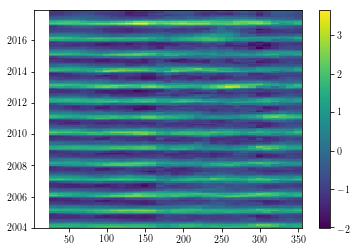

In [54]:
plt.pcolormesh(bin_centres, argo_T_bins.TIME, argo_T_bins[:,0,:])
plt.colorbar()

/anaconda3/envs/py36/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


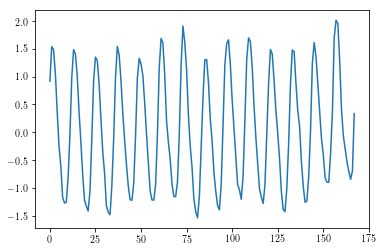

In [55]:
plt.plot(argo_T_bins[:,0,5])

In [27]:
mnth_regional_slopes = np.zeros((12, nbins))
mnth_regional_intercepts = np.zeros((12, nbins))
mnth_regional_rvalues = np.zeros((12, nbins))
mnth_regional_pvalues = np.zeros((12, nbins))
mnth_regional_stderrs = np.zeros((12, nbins))

month_abbrs = ['JAN', 'FEB', 'MAR', 'APR', 'MAY', 'JUN', 'JUL', 'AUG', 'SEP', 'OCT', 'NOV', 'DEC']

for lonbin in range(nbins):
    # regress regional wind and regional ice extent by month
    f, axarr = plt.subplots(3, 4, sharex='col', sharey='row', figsize=(18,12))

    for month in range(12):
        j = int(np.floor(month/4))
        i = np.mod(month,4)

        wind = v70_bins.sel(time=is_month(v70_bins['time.month'], month + 1)).loc[dict(
            time=np.arange('2004-{:02d}'.format(month+1),'2017', '12', dtype='datetime64'),
            longitude_bins=v70_bins.longitude_bins[lonbin])]
        wind_mean = wind.mean()
        wind = wind - wind.mean()
        
        sst = argo_T_bins.sel(TIME=is_month(argo_T_bins['TIME.month'], month + 1)).loc[dict(
            TIME=np.arange('2004-{:02d}'.format(month+1),'2017', '12', dtype='datetime64'),
            LONGITUDE_bins=argo_T_bins.LONGITUDE_bins[lonbin],
            PRESSURE=2.5)]
        # SIE_trimmed.loc[SIE_trimmed.index.month==month+1][SIE_trimmed.columns[lonbin+1]]
        sst = sst - sst.mean()

        (mnth_regional_slopes[month, lonbin], mnth_regional_intercepts[month, lonbin], mnth_regional_rvalues[month, lonbin], 
        mnth_regional_pvalues[month, lonbin], mnth_regional_stderrs[month, lonbin]) = scipy.stats.linregress(
                            wind, sst)    

        axarr[j,i].plot(wind, sst, 'o')
        if mnth_regional_pvalues[month,lonbin] <= 0.05/12./36:
            axarr[j,i].set_title('{} p-value = {:.04f} \n mean wind = {:.02f} m/s'.format(
                calendar.month_name[month+1], mnth_regional_pvalues[month,lonbin], float(wind_mean.data)), 
                                 fontsize=15, color='magenta')
        else:
            axarr[j,i].set_title('{} p-value = {:.04f} \n mean wind = {:.02f} m/s'.format(
                calendar.month_name[month+1], mnth_regional_pvalues[month,lonbin], float(wind_mean.data)), 
                                 fontsize=15)

        wind = np.linspace(wind.min(), wind.max(), 100)
        axarr[j,i].plot(wind, wind*mnth_regional_slopes[month, lonbin] + mnth_regional_intercepts[month, lonbin])
        axarr[j,i].text(0.05, 0.95, 'R$^2$={:.03f}'.format(mnth_regional_rvalues[month, lonbin]**2),
                        transform=axarr[j,i].transAxes)

    axarr[0,0].set_ylabel('SST anomaly', fontsize='15')
    axarr[1,0].set_ylabel('SST anomaly', fontsize='15')
    axarr[2,0].set_ylabel('SST anomaly', fontsize='15')
    axarr[2,0].set_xlabel('Meridional wind anomaly', fontsize='15')
    axarr[2,1].set_xlabel('Meridional wind anomaly', fontsize='15')
    axarr[2,2].set_xlabel('Meridional wind anomaly', fontsize='15')
    axarr[2,3].set_xlabel('Meridional wind anomaly', fontsize='15')
    f.suptitle('Longitude range = {0}'.format(v70_bins.longitude_bins[lonbin].data), fontsize=15)


    plt.savefig('/Users/doddridge/Desktop/SIE_regresssion/70S_merid_wind_Vs_SST_lonbin_{0}.pdf'.format(
                v70_bins.longitude_bins[lonbin].data), bbox_inches='tight')
    plt.close()

/anaconda3/envs/py36/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/anaconda3/envs/py36/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/anaconda3/envs/py36/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/anaconda3/envs/py36/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/anaconda3/envs/py36/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] n

## YZ slice of temperature anomalies

See how the wind-induced ice movement and melt has contributed to temperature anomalies. Use lagged regression and annual means as a first step.

In [109]:

ndepths = 58
nlats=30

argo_T_bins = argo_T.ARGO_TEMPERATURE_ANOMALY.loc[dict(LATITUDE=np.linspace(-64.5, -64.5+nlats-1, nlats))].groupby_bins('LONGITUDE',
                        np.linspace(0,360,nbins+1)).mean(dim=['LONGITUDE'])
argo_T_bins_ann_mean = argo_T_bins.groupby('TIME.year').mean(dim=['TIME'])
v_70_ann_mean = v70_bins.groupby('time.year').mean(dim=['time'])

/anaconda3/envs/py36/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


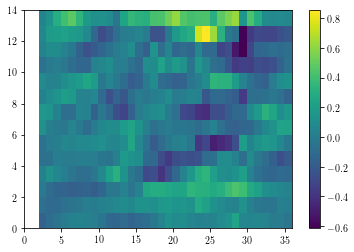

In [114]:
plt.pcolormesh(argo_T_bins_ann_mean[:,0,5,:])
plt.colorbar()

In [89]:


lagged_ann_mean_regional_slopes = argo_T_bins_ann_mean.copy(deep=True).rename('lagged_ann_mean_regional_slopes').rename({'year':'lag'})*np.nan
# lagged_ann_mean_regional_slopes = lagged_ann_mean_regional_slopes.rename({'year':'lag'})
lagged_ann_mean_regional_slopes['lag'] = np.arange(14)

lagged_ann_mean_regional_intercepts = lagged_ann_mean_regional_slopes.copy(deep=True).rename('lagged_ann_mean_regional_intercepts')
lagged_ann_mean_regional_rvalues = lagged_ann_mean_regional_slopes.copy(deep=True).rename('lagged_ann_mean_regional_rvalues')
lagged_ann_mean_regional_pvalues = lagged_ann_mean_regional_slopes.copy(deep=True).rename('lagged_ann_mean_regional_pvalues')
lagged_ann_mean_regional_stderrs = lagged_ann_mean_regional_slopes.copy(deep=True).rename('lagged_ann_mean_regional_stderrs')

for lonbin in range(nbins):
    for j in range(nlats):
        for k in range(ndepths):
        #     f, axarr = plt.subplots(3, 4, sharex='col', sharey='row', figsize=(18,12))

            for lag in range(12):
#                 j = int(np.floor(lag/4))
#                 i = np.mod(lag,4)

                wind = v_70_ann_mean.loc[dict(year=np.arange(2004-lag,int(2018-lag)),
                                              longitude_bins=v70_bins.longitude_bins[lonbin])]
                wind_mean = wind.mean()
                wind = wind - wind.mean()

                sst = argo_T_bins_ann_mean.loc[dict(
                    year=np.arange(2004, 2018),
                    LONGITUDE_bins=argo_T_bins.LONGITUDE_bins[lonbin],
                    PRESSURE=argo_T_bins_ann_mean.PRESSURE[k],
                    LATITUDE=argo_T_bins_ann_mean.LATITUDE[j])]
                # SIE_trimmed.loc[SIE_trimmed.index.month==month+1][SIE_trimmed.columns[lonbin+1]]
                sst = sst - sst.mean()

                (lagged_ann_mean_regional_slopes[lag,k,j,lonbin],
                 lagged_ann_mean_regional_intercepts[lag,k,j,lonbin],
                 lagged_ann_mean_regional_rvalues[lag,k,j,lonbin],
                 lagged_ann_mean_regional_pvalues[lag,k,j,lonbin],
                 lagged_ann_mean_regional_stderrs[lag,k,j,lonbin]) = scipy.stats.linregress(wind, sst)

#         axarr[j,i].plot(wind, sst, 'o')
#         if lagged_ann_mean_regional_pvalues[month,lonbin] <= 0.05/12./36:
#             axarr[j,i].set_title('{} p-value = {:.04f} \n mean wind = {:.02f} m/s'.format(
#                 calendar.month_name[month+1], lagged_ann_mean_regional_pvalues[lag,lonbin], float(wind_mean.data)), 
#                                  fontsize=15, color='magenta')
#         else:
#             axarr[j,i].set_title('{} p-value = {:.04f} \n mean wind = {:.02f} m/s'.format(
#                 calendar.month_name[month+1], lagged_ann_mean_regional_pvalues[lag,lonbin], float(wind_mean.data)), 
#                                  fontsize=15)

#         wind = np.linspace(wind.min(), wind.max(), 100)
#         axarr[j,i].plot(wind, wind*lagged_ann_mean_regional_slopes[lag, lonbin] + lagged_ann_mean_regional_intercepts[lag, lonbin])
#         axarr[j,i].text(0.05, 0.95, 'R$^2$={:.03f}'.format(lagged_ann_mean_regional_rvalues[lag, lonbin]**2),
#                         transform=axarr[j,i].transAxes)

#     axarr[0,0].set_ylabel('SST anomaly', fontsize='15')
#     axarr[1,0].set_ylabel('SST anomaly', fontsize='15')
#     axarr[2,0].set_ylabel('SST anomaly', fontsize='15')
#     axarr[2,0].set_xlabel('Meridional wind anomaly', fontsize='15')
#     axarr[2,1].set_xlabel('Meridional wind anomaly', fontsize='15')
#     axarr[2,2].set_xlabel('Meridional wind anomaly', fontsize='15')
#     axarr[2,3].set_xlabel('Meridional wind anomaly', fontsize='15')
#     f.suptitle('Longitude range = {0}'.format(v70_bins.longitude_bins[lonbin].data), fontsize=15)


#     plt.savefig('/Users/doddridge/Desktop/SIE_regresssion/70S_merid_wind_Vs_SST_lonbin_{0}.pdf'.format(
#                 v70_bins.longitude_bins[lonbin].data), bbox_inches='tight')
#     plt.close()

In [90]:
lagged_ann_mean_regional_slopes

<xarray.DataArray 'lagged_ann_mean_regional_slopes' (lag: 14, PRESSURE: 58, LATITUDE: 15, LONGITUDE_bins: 36)>
array([[[[      nan, ...,       nan],
         ...,
         [      nan, ..., -0.014691]],

        ...,

        [[      nan, ...,       nan],
         ...,
         [      nan, ...,       nan]]],


       ...,


       [[[      nan, ...,       nan],
         ...,
         [      nan, ...,       nan]],

        ...,

        [[      nan, ...,       nan],
         ...,
         [      nan, ...,       nan]]]], dtype=float32)
Coordinates:
  * LONGITUDE_bins  (LONGITUDE_bins) object (0.0, 10.0] (10.0, 20.0] ...
  * LATITUDE        (LATITUDE) float32 -64.5 -63.5 -62.5 -61.5 -60.5 -59.5 ...
  * PRESSURE        (PRESSURE) float32 2.5 10.0 20.0 30.0 40.0 50.0 60.0 ...
  * lag             (lag) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13

/anaconda3/envs/py36/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


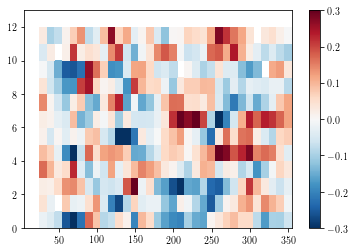

In [92]:
plt.pcolormesh(bin_centres, np.arange(14), np.ma.masked_where(lagged_ann_mean_regional_pvalues[:,0,3,:]>0.99, lagged_ann_mean_regional_slopes[:,0,3,:]),
               vmin=-0.3, vmax=0.3, cmap='RdBu_r')
plt.colorbar()

/anaconda3/envs/py36/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


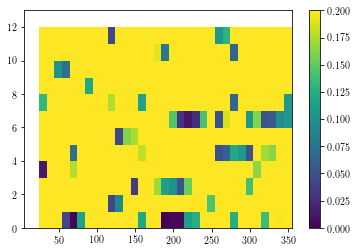

In [93]:
plt.pcolormesh(bin_centres, np.arange(14), lagged_ann_mean_regional_pvalues[:,0,3,:], vmin=0, vmax=.2)
plt.colorbar()

/anaconda3/envs/py36/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


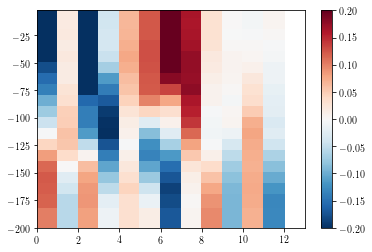

In [95]:
plt.pcolormesh(np.arange(14), -argo_T_bins_ann_mean.PRESSURE[:20], lagged_ann_mean_regional_slopes[:,:20,3,20].transpose(),
              vmin=-0.2, vmax=0.2, cmap='RdBu_r')
plt.colorbar()

(-200, 0)

/anaconda3/envs/py36/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


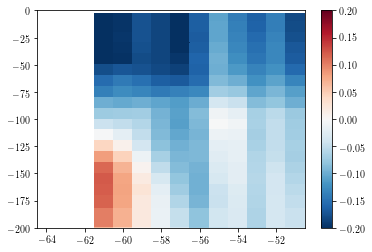

In [104]:
plt.pcolormesh(argo_T_bins_ann_mean.LATITUDE, -argo_T_bins_ann_mean.PRESSURE, lagged_ann_mean_regional_slopes[0,:,:,20],
              vmin=-0.2, vmax=0.2, cmap='RdBu_r')
plt.colorbar()
plt.ylim(-200,0)